In [1]:
# импортируем все что нужно

import numpy as np
import pandas as pd
from pathlib import Path
import copy

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import torch.nn.functional as F
import math

from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc

In [2]:
# пути для инпут файлов, в папке faces_aligned_pred_all лежат изображения выровненные с помощью 2_Face_alignment.ipynb
# в aligned_pred_all.csv лежат image_id и identity для этих изображений

data_path = Path("/kaggle/input/data-for-recognition/faces_aligned_pred_all")
csv_path = data_path / "aligned_pred_all.csv"

In [3]:
# проверяем сколько у нас всего выровненных изображений
file_count = len([f for f in data_path.iterdir() if f.is_file()])
file_count

25001

In [4]:
# проверяем что все выглядит ок
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(25000, 2)


,image_id,identity
0,136627.jpg,3511
1,039611.jpg,7511
2,090411.jpg,6730
3,201044.jpg,7012
4,041575.jpg,5637


Text(0.5, 1.0, 'Distribution of Images per Identity')

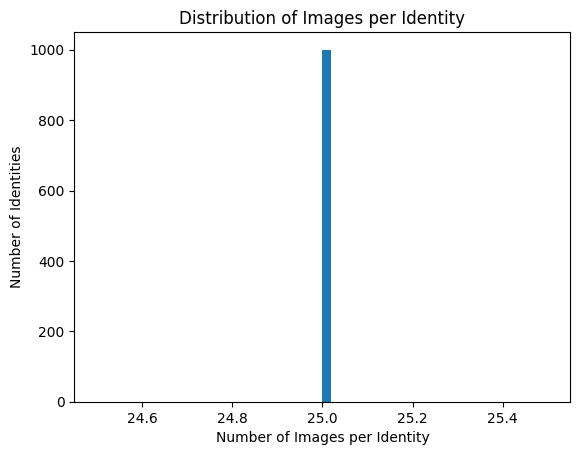

In [5]:
# проверяем что все выглядит ок
identity_counts = df['identity'].value_counts()
plt.hist(identity_counts, bins=50)
plt.xlabel("Number of Images per Identity")
plt.ylabel("Number of Identities")
plt.title("Distribution of Images per Identity")

In [6]:
output_dir_cropped = Path("/kaggle/working/faces_recognition_224")    
output_dir_cropped.mkdir(parents=True, exist_ok=True)

# так как будем использовать реснет, но дополнительно обрежем картинки до 224x224
CROP_SIZE = 224

def center_crop(img, crop_size):
    w, h = img.size
    left = (w - crop_size) // 2
    top = (h - crop_size) // 2
    return img.crop((left, top, left + crop_size, top + crop_size))

for p in tqdm(sorted(data_path.glob("*"))):

    if p.suffix.lower() == ".csv":
        continue
    
    img = Image.open(p).convert("RGB")

    crop = center_crop(img, CROP_SIZE)

    out_path = output_dir_cropped / (p.stem + ".jpg")
    crop.save(out_path, format="JPEG")

100%|██████████| 25001/25001 [02:06<00:00, 197.62it/s]


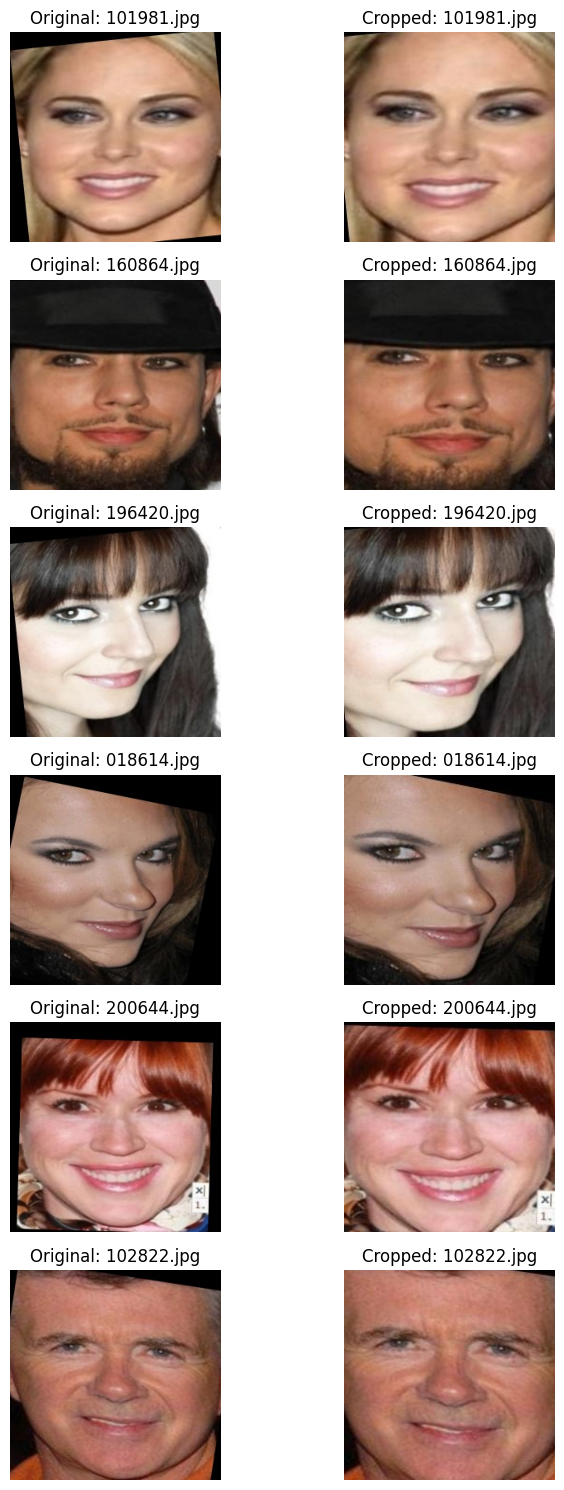

In [7]:
# отрисуем 6 рандомных картинок, чтоб проверить, что все с обрезанием все ок

sample = df.sample(6)

fig, axes = plt.subplots(6, 2, figsize=(8, 15))

for i, row in enumerate(sample.itertuples()):

    axes[i, 0].set_title(f"Original: {row.image_id}")
    img = Image.open(data_path / row.image_id)
    axes[i, 0].imshow(img)
    axes[i, 0].axis("off")

    axes[i, 1].set_title(f"Cropped: {row.image_id}")
    img_cropped = Image.open(output_dir_cropped / row.image_id)
    axes[i, 1].imshow(img_cropped)
    axes[i, 1].axis("off")

plt.tight_layout()

In [8]:
SEED = 21
TRAIN_PER_ID, VAL_PER_ID, TEST_PER_ID = 18, 4, 3 # такая разбивка показалась мне наиболее разумной
PER_ID_TOTAL = TRAIN_PER_ID + VAL_PER_ID + TEST_PER_ID

In [9]:
output_dir_splits = Path("/kaggle/working/splits")    
output_dir_splits.mkdir(parents=True, exist_ok=True)

for split in ["train", "val", "test"]:
    (output_dir_splits / split).mkdir(parents=True, exist_ok=True)

In [10]:
rng = np.random.RandomState(SEED)

rows_out = []

# тут мы проходим по всем identities и для заданной identity выбираем TRAIN_PER_ID картинок в train, VAL_PER_ID в val и тд
for ident, g in tqdm(df.groupby("identity"), total=df["identity"].nunique()):
    g = g.sample(frac=1.0, random_state=SEED).reset_index(drop=True)  
    g = g.iloc[:PER_ID_TOTAL].copy()  

    split_labels = (["train"] * TRAIN_PER_ID) + (["val"] * VAL_PER_ID) + (["test"] * TEST_PER_ID)
    g["split"] = split_labels

    for _, r in g.iterrows():

        src = output_dir_cropped / r["image_id"]
        dst_dir = output_dir_splits / r["split"] / str(r["identity"])
        dst_dir.mkdir(parents=True, exist_ok=True)
        dst = dst_dir / src.name
        shutil.copy2(src, dst)

    rows_out.append(g[["image_id", "identity", "split"]])

df_split = pd.concat(rows_out, axis=0).reset_index(drop=True)

df_split[df_split["split"]=="train"].to_csv(output_dir_splits / "train.csv", index=False)
df_split[df_split["split"]=="val"].to_csv(output_dir_splits / "val.csv", index=False)
df_split[df_split["split"]=="test"].to_csv(output_dir_splits / "test.csv", index=False)

100%|██████████| 1000/1000 [00:09<00:00, 106.42it/s]


In [11]:
DATA_ROOT = Path("/kaggle/working/recog_split")
BATCH_SIZE = 128
NUM_WORKERS = 2  

# ImageNet нормализация
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# тут я еще сверху добавил всяких преобразований, они дали норм буст в accuracy
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(output_dir_splits / "train", transform=train_tfms)
val_ds   = datasets.ImageFolder(output_dir_splits / "val",   transform=eval_tfms)
test_ds  = datasets.ImageFolder(output_dir_splits / "test",  transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print(len(train_ds.classes), len(val_ds.classes), len(test_ds.classes))
print(len(train_ds), len(val_ds), len(test_ds))

1000 1000 1000
18000 4000 3000


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_ds.classes)

In [13]:
EPOCHS = 30

In [14]:
# стандартный подсчет accuracy_top1
def accuracy_top1(logits, labels):
    correct = 0
    total = labels.size(0)

    for i in range(total):
        scores = logits[i]         
        true_label = labels[i]

        predicted_label = torch.argmax(scores)

        if predicted_label == true_label:
            correct += 1

    return correct / total

**########################**

**ниже тренируем с CE**

**########################**

In [15]:
# тут все стандартно
@torch.no_grad()
def evaluate_ce(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

In [16]:
# тут все стандартно
def train_one_epoch_ce(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

In [17]:
best_val_acc = -1.0
BEST_PATH_CE = "/kaggle/working/best_ce.pth"

In [18]:
# я попробовал пару моделей, resnet50 показала лучшие результаты
model_ce = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model_ce.fc = nn.Linear(model_ce.fc.in_features, num_classes)
model_ce = model_ce.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


In [19]:
# тут все стандартно
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_ce.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [20]:
# тренируем с CE

history_ce = []

history_ce = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch_ce(model_ce, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_ce(model_ce, val_loader, criterion, device)
    scheduler.step()

    history_ce["train_loss"].append(train_loss)
    history_ce["val_loss"].append(val_loss)
    history_ce["train_acc"].append(train_acc)
    history_ce["val_acc"].append(val_acc)
    
    print(f"Epoch {epoch:02d} train_loss={train_loss:.4f} train_acc = {train_acc:.4f} val_loss={val_loss:.4f} val_acc = {val_acc:.4f} ")

    # сохраняем веса лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state_dict": model_ce.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": best_val_acc,
            "classes": train_ds.classes,
            "meta": {
                "arch": "CE",
                "backbone": "resnet50",
                "input_size": 224,
            },
        }, BEST_PATH_CE)
        print(f"!!! Saved best checkpoint, val_acc={best_val_acc:.4f})")

Epoch 01 train_loss=6.4886 train_acc = 0.0134 val_loss=5.6551 val_acc = 0.0527 
!!! Saved best checkpoint, val_acc=0.0527)


Epoch 02 train_loss=4.7630 train_acc = 0.1693 val_loss=4.5821 val_acc = 0.1995 
!!! Saved best checkpoint, val_acc=0.1995)


Epoch 03 train_loss=3.4050 train_acc = 0.4541 val_loss=3.4181 val_acc = 0.4602 
!!! Saved best checkpoint, val_acc=0.4602)


Epoch 04 train_loss=2.5425 train_acc = 0.6849 val_loss=3.0107 val_acc = 0.5675 
!!! Saved best checkpoint, val_acc=0.5675)


Epoch 05 train_loss=1.9962 train_acc = 0.8384 val_loss=2.7638 val_acc = 0.6272 
!!! Saved best checkpoint, val_acc=0.6272)


Epoch 06 train_loss=1.6606 train_acc = 0.9299 val_loss=2.4688 val_acc = 0.7083 
!!! Saved best checkpoint, val_acc=0.7083)


Epoch 07 train_loss=1.4535 train_acc = 0.9744 val_loss=2.3029 val_acc = 0.7585 
!!! Saved best checkpoint, val_acc=0.7585)


Epoch 08 train_loss=1.3339 train_acc = 0.9915 val_loss=2.2341 val_acc = 0.7715 
!!! Saved best checkpoint, val_acc=0.7715)


Epoch 09 train_loss=1.2619 train_acc = 0.9977 val_loss=2.1103 val_acc = 0.7997 
!!! Saved best checkpoint, val_acc=0.7997)


Epoch 10 train_loss=1.2198 train_acc = 0.9993 val_loss=2.0640 val_acc = 0.8170 
!!! Saved best checkpoint, val_acc=0.8170)


Epoch 11 train_loss=1.1882 train_acc = 0.9995 val_loss=2.0666 val_acc = 0.8263 
!!! Saved best checkpoint, val_acc=0.8263)


Epoch 12 train_loss=1.1663 train_acc = 0.9997 val_loss=2.0269 val_acc = 0.8377 
!!! Saved best checkpoint, val_acc=0.8377)


Epoch 13 train_loss=1.1519 train_acc = 0.9998 val_loss=2.0036 val_acc = 0.8465 
!!! Saved best checkpoint, val_acc=0.8465)


Epoch 14 train_loss=1.1388 train_acc = 0.9997 val_loss=2.0112 val_acc = 0.8478 
!!! Saved best checkpoint, val_acc=0.8478)


Epoch 15 train_loss=1.1286 train_acc = 0.9997 val_loss=1.9980 val_acc = 0.8540 
!!! Saved best checkpoint, val_acc=0.8540)


Epoch 16 train_loss=1.1189 train_acc = 0.9999 val_loss=1.9875 val_acc = 0.8585 
!!! Saved best checkpoint, val_acc=0.8585)


Epoch 17 train_loss=1.1106 train_acc = 0.9998 val_loss=2.0044 val_acc = 0.8670 
!!! Saved best checkpoint, val_acc=0.8670)


Epoch 18 train_loss=1.1036 train_acc = 0.9997 val_loss=1.9854 val_acc = 0.8665 


Epoch 19 train_loss=1.0970 train_acc = 0.9998 val_loss=1.9919 val_acc = 0.8725 
!!! Saved best checkpoint, val_acc=0.8725)


Epoch 20 train_loss=1.0911 train_acc = 0.9998 val_loss=1.9830 val_acc = 0.8742 
!!! Saved best checkpoint, val_acc=0.8742)


Epoch 21 train_loss=1.0865 train_acc = 0.9999 val_loss=1.9873 val_acc = 0.8790 
!!! Saved best checkpoint, val_acc=0.8790)


Epoch 22 train_loss=1.0821 train_acc = 0.9999 val_loss=1.9952 val_acc = 0.8772 


Epoch 23 train_loss=1.0786 train_acc = 0.9998 val_loss=1.9891 val_acc = 0.8830 
!!! Saved best checkpoint, val_acc=0.8830)


Epoch 24 train_loss=1.0759 train_acc = 0.9999 val_loss=2.0014 val_acc = 0.8842 
!!! Saved best checkpoint, val_acc=0.8842)


Epoch 25 train_loss=1.0733 train_acc = 0.9999 val_loss=2.0014 val_acc = 0.8860 
!!! Saved best checkpoint, val_acc=0.8860)


Epoch 26 train_loss=1.0716 train_acc = 0.9999 val_loss=1.9928 val_acc = 0.8872 
!!! Saved best checkpoint, val_acc=0.8872)


Epoch 27 train_loss=1.0701 train_acc = 0.9999 val_loss=2.0003 val_acc = 0.8862 


Epoch 28 train_loss=1.0691 train_acc = 0.9999 val_loss=2.0001 val_acc = 0.8860 


Epoch 29 train_loss=1.0686 train_acc = 0.9999 val_loss=2.0046 val_acc = 0.8865 


Epoch 30 train_loss=1.0680 train_acc = 0.9999 val_loss=2.0048 val_acc = 0.8870 


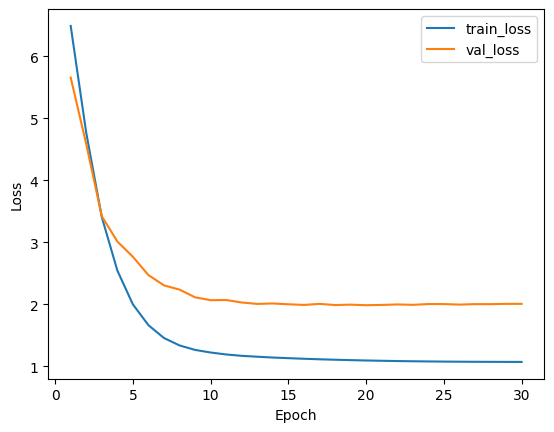

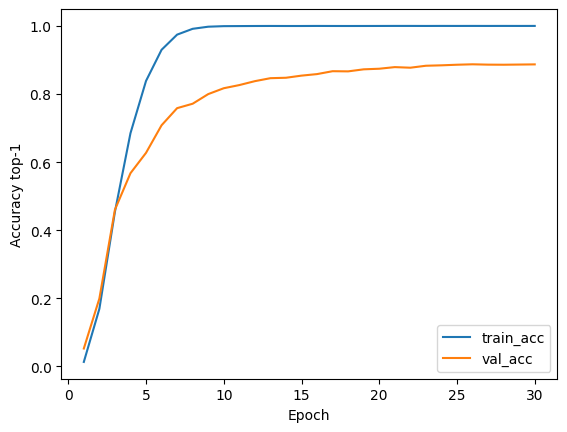

In [21]:
# отрисуем лоссы и accuracy как функции количества эпо   

epochs = range(1, len(history_ce["train_loss"]) + 1)

plt.figure()
plt.plot(list(epochs), history_ce["train_loss"])
plt.plot(list(epochs), history_ce["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train_loss", "val_loss"])
plt.show()

plt.figure()
plt.plot(list(epochs), history_ce["train_acc"])
plt.plot(list(epochs), history_ce["val_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy top-1")
plt.legend(["train_acc", "val_acc"])
plt.show()

In [22]:
# загрузим лучшую модель

ckpt = torch.load(BEST_PATH_CE, map_location=device)
best_model_ce = copy.deepcopy(model_ce)
best_model_ce.load_state_dict(ckpt["model_state_dict"])
best_model_ce.to(device).eval()
print("Best epoch:", ckpt.get("epoch"), "best_val_acc:", ckpt.get("best_val_acc"))

Best epoch: 26 best_val_acc: 0.88725


In [23]:
# посчитаем аккураси на лучшей моделе на тесте

test_loss, test_acc = evaluate_ce(best_model_ce, test_loader, criterion, device)
print("CE test acc:", test_acc)

CE test acc: 0.885


**########################**

**ниже тренируем с ArcFace**

**########################**

In [24]:
# все стандартно

@torch.no_grad()
def evaluate_af(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        logits, emb = model(x, labels=None) # тут маржин не нужен!
        loss = criterion(logits, y)
        
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

In [25]:
# все стандартно

def train_one_epoch_af(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        logits, emb = model(x, labels=y) # применяем маржин!      
        loss = criterion(logits, y)
        
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

In [26]:
best_val_acc = -1.0
BEST_PATH_AF = "/kaggle/working/best_af.pth"

In [27]:
# ArcFace голова
class ArcMarginProduct(nn.Module):
 
    def __init__(self, in_features, out_features, s, m):
        super().__init__()

        self.in_features = in_features # размерность эмбеддинга
        self.out_features = out_features # число identites

        self.s = float(s) # масштаб логитов 
        self.m = float(m) # угловой маржин

        self.weight = nn.Parameter(torch.empty(out_features, in_features)) # матрица весов классов, каждая строка это "центр" класса в пространстве эмбеддингов
        nn.init.xavier_uniform_(self.weight) 

        # Предварительно считаем cos(m), sin(m) для формулы:
        # cos(theta + m) = cos(theta)*cos(m) - sin(theta)*sin(m)
        self.cos_m = math.cos(self.m) 
        self.sin_m = math.sin(self.m)

        # порог и поправка для численной стабильности 
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m) * self.m

    def forward(self, embeddings, labels=None):

        # L2-нормализация эмбеддингов и весов:
        embeddings = F.normalize(embeddings, p=2, dim=1)      
        weight = F.normalize(self.weight, p=2, dim=1)        

        # перемножаем их
        cosine = F.linear(embeddings, weight)              

        # Если labels нет, то возвращаем чистые cosine * s
        # маржин нужен только при обучении чтобы формировать пространство эмбеддингов
        if labels is None:
            return cosine * self.s

        # считаем sin(theta) = sqrt(1 - cos^2(theta))
        # clamp нужен, чтобы не получить отрицательное из-за численных ошибок
        sine = torch.sqrt(torch.clamp(1.0 - cosine**2, min=0.0))

        # читаем phi = cos(theta + m) по формуле, вот и пригодилась тригонометрия!
        phi = cosine * self.cos_m - sine * self.sin_m        

        # если cosine слишком маленький (угол тета слишком большой), то вместе phi = cos(theta + m) используем phi = cosine - mm
        # это делается для численной стабильности, потому что если teta + m окажется больше pi, то cos перестанет быть монотонной функцией угла и у нас будут проблемы с обучением
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        # оne-hot для выбора ground-truth в каждом примере
        one_hot = torch.zeros_like(cosine)                    
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        # для правильного класса phi = cos(theta + m)
        # для остальных классов cosine = cos(theta)
        logits = one_hot * phi + (1.0 - one_hot) * cosine

        # масштабируем логиты
        logits = logits * self.s
        return logits


In [28]:
# сама ArcFace модель

class ArcFaceModel(nn.Module):
    def __init__(self, backbone, embedder, head):
        super().__init__()
        self.backbone = backbone
        self.embedder = embedder
        self.head = head

    def forward(self, x, labels=None):
        # backbone извлекает признаки
        features = self.backbone(x)

        # embedder переводит признаки в пространстве эмбеддингов
        emb = self.embedder(features)

        # ArcFace голова считает логиты
        logits = self.head(emb, labels)

        return logits, emb

In [29]:
# берем опять resnet50 в качестве backbone

backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
in_features = backbone.fc.in_features
backbone.fc = nn.Identity()  # выкидываем классификатор

EMB_DIM = 512 # размерность эмбеддинга, как в оригинальной статье ArcFace

# строим embedder
embedder = nn.Sequential(
    nn.Linear(in_features, EMB_DIM, bias=False),
    nn.BatchNorm1d(EMB_DIM),
)

# дефотльные гиперпараметры для ArcFace
S = 30.0
M = 0.50
head = ArcMarginProduct(EMB_DIM, num_classes, s=S, m=M)

model_af = ArcFaceModel(backbone, embedder, head).to(device)

In [30]:
# все как и для CE
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_af.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [31]:
# тоже все как для CE

history_af = []

history_af = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch_af(model_af, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_af(model_af, val_loader, criterion, device)
    scheduler.step()

    history_af["train_loss"].append(train_loss)
    history_af["val_loss"].append(val_loss)
    history_af["train_acc"].append(train_acc)
    history_af["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} train_loss={train_loss:.4f} train_acc = {train_acc:.4f} val_loss={val_loss:.4f} val_acc = {val_acc:.4f} ")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "best_val_acc": best_val_acc,
            "model_state_dict": model_af.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "classes": train_ds.classes,
            "arcface_s": S,
            "arcface_m": M,
            "emb_dim": EMB_DIM,
            "meta": {
                "arch": "ArcFace",
                "backbone": "resnet50",
                "input_size": 224,
            },
        }, BEST_PATH_AF)
        print(f"!!! Saved best checkpoint, val_acc={best_val_acc:.4f}")

Epoch 01 train_loss=19.0208 train_acc = 0.0000 val_loss=4.5042 val_acc = 0.2273 
!!! Saved best checkpoint, val_acc=0.2273


Epoch 02 train_loss=15.8215 train_acc = 0.0011 val_loss=2.9722 val_acc = 0.5790 
!!! Saved best checkpoint, val_acc=0.5790


Epoch 03 train_loss=12.2728 train_acc = 0.0170 val_loss=2.4995 val_acc = 0.7360 
!!! Saved best checkpoint, val_acc=0.7360


Epoch 04 train_loss=9.0771 train_acc = 0.0922 val_loss=2.3257 val_acc = 0.8455 
!!! Saved best checkpoint, val_acc=0.8455


Epoch 05 train_loss=6.8547 train_acc = 0.2105 val_loss=2.3253 val_acc = 0.8725 
!!! Saved best checkpoint, val_acc=0.8725


Epoch 06 train_loss=5.3265 train_acc = 0.3461 val_loss=2.3241 val_acc = 0.8980 
!!! Saved best checkpoint, val_acc=0.8980


Epoch 07 train_loss=4.2311 train_acc = 0.4699 val_loss=2.3414 val_acc = 0.9042 
!!! Saved best checkpoint, val_acc=0.9042


Epoch 08 train_loss=3.4103 train_acc = 0.5885 val_loss=2.3496 val_acc = 0.9133 
!!! Saved best checkpoint, val_acc=0.9133


Epoch 09 train_loss=2.7685 train_acc = 0.6931 val_loss=2.3682 val_acc = 0.9170 
!!! Saved best checkpoint, val_acc=0.9170


Epoch 10 train_loss=2.2920 train_acc = 0.7883 val_loss=2.3759 val_acc = 0.9180 
!!! Saved best checkpoint, val_acc=0.9180


Epoch 11 train_loss=1.9567 train_acc = 0.8613 val_loss=2.3818 val_acc = 0.9235 
!!! Saved best checkpoint, val_acc=0.9235


Epoch 12 train_loss=1.7493 train_acc = 0.9089 val_loss=2.3819 val_acc = 0.9233 


Epoch 13 train_loss=1.6008 train_acc = 0.9458 val_loss=2.3744 val_acc = 0.9260 
!!! Saved best checkpoint, val_acc=0.9260


Epoch 14 train_loss=1.5222 train_acc = 0.9631 val_loss=2.3600 val_acc = 0.9230 


Epoch 15 train_loss=1.4629 train_acc = 0.9765 val_loss=2.3631 val_acc = 0.9253 


Epoch 16 train_loss=1.4253 train_acc = 0.9814 val_loss=2.3408 val_acc = 0.9290 
!!! Saved best checkpoint, val_acc=0.9290


Epoch 17 train_loss=1.3958 train_acc = 0.9867 val_loss=2.3339 val_acc = 0.9285 


Epoch 18 train_loss=1.3638 train_acc = 0.9916 val_loss=2.3232 val_acc = 0.9295 
!!! Saved best checkpoint, val_acc=0.9295


Epoch 19 train_loss=1.3419 train_acc = 0.9938 val_loss=2.3048 val_acc = 0.9327 
!!! Saved best checkpoint, val_acc=0.9327


Epoch 20 train_loss=1.3244 train_acc = 0.9948 val_loss=2.3008 val_acc = 0.9290 


Epoch 21 train_loss=1.3091 train_acc = 0.9959 val_loss=2.2944 val_acc = 0.9313 


Epoch 22 train_loss=1.2930 train_acc = 0.9966 val_loss=2.2916 val_acc = 0.9313 


Epoch 23 train_loss=1.2806 train_acc = 0.9980 val_loss=2.2813 val_acc = 0.9300 


Epoch 24 train_loss=1.2698 train_acc = 0.9980 val_loss=2.2743 val_acc = 0.9305 


Epoch 25 train_loss=1.2596 train_acc = 0.9984 val_loss=2.2736 val_acc = 0.9315 


Epoch 26 train_loss=1.2536 train_acc = 0.9989 val_loss=2.2703 val_acc = 0.9327 


Epoch 27 train_loss=1.2516 train_acc = 0.9984 val_loss=2.2680 val_acc = 0.9310 


Epoch 28 train_loss=1.2470 train_acc = 0.9991 val_loss=2.2705 val_acc = 0.9313 


Epoch 29 train_loss=1.2444 train_acc = 0.9990 val_loss=2.2702 val_acc = 0.9320 


Epoch 30 train_loss=1.2427 train_acc = 0.9990 val_loss=2.2693 val_acc = 0.9303 


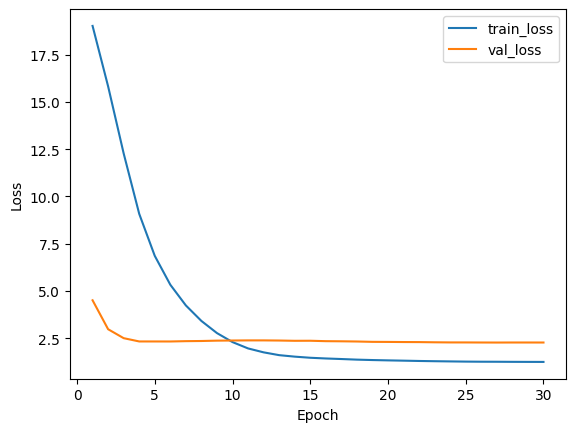

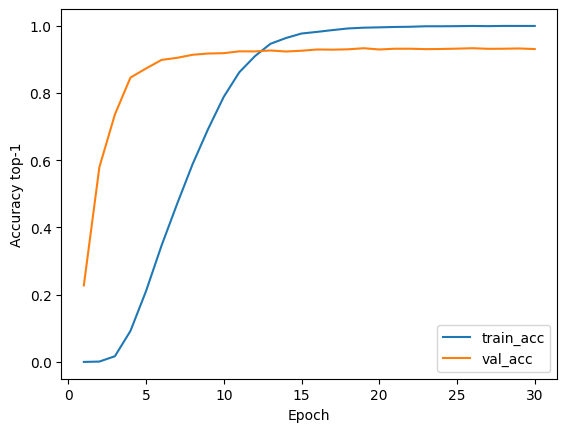

In [32]:
# отрисуем лоссы и accuracy как функции количества эпоx  

epochs = range(1, len(history_af["train_loss"]) + 1)

plt.figure()
plt.plot(list(epochs), history_af["train_loss"])
plt.plot(list(epochs), history_af["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train_loss", "val_loss"])
plt.show()

plt.figure()
plt.plot(list(epochs), history_af["train_acc"])
plt.plot(list(epochs), history_af["val_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy top-1")
plt.legend(["train_acc", "val_acc"])
plt.show()

In [33]:
# загрузим лучшую модель
ckpt = torch.load(BEST_PATH_AF, map_location=device)
best_model_af = copy.deepcopy(model_af)
best_model_af.load_state_dict(ckpt["model_state_dict"])
best_model_af.to(device).eval()
print("Best epoch:", ckpt.get("epoch"), "best_val_acc:", ckpt.get("best_val_acc"))

Best epoch: 19 best_val_acc: 0.93275


In [34]:
# посчитаем аккураси на лучшей моделе на тесте
test_loss, test_acc = evaluate_af(best_model_af, test_loader, criterion, device)
print("AF test acc:", test_acc)

AF test acc: 0.9306666666666666


**########################**

**ниже мы делаем всякие визуализации для сравнения CE и AF**

**########################**

In [35]:
# будем использовать тест для визуализаций
ds_viz = test_ds

# количество идентичностей и картинок на идентичность для t-SNE 
K_IDENTITIES = 50
N_PER_ID = 3

In [36]:
# вытаскиваем эмбеддер из CE модели (то есть выкидываем последний линейный слой)
ce_emb_model = copy.deepcopy(best_model_ce)
ce_emb_model.fc = torch.nn.Identity()
ce_emb_model = ce_emb_model.to(device).eval()

# Arcface модель уже содержит эмбеддер
arc_model = best_model_af.to(device).eval()

In [37]:
# считаем эмбеддинги для батча картинок x

@torch.no_grad()
def ce_forward_embeddings(model, x):
    z = model(x)  
    if isinstance(z, (tuple, list)):
        z = z[0]
    z = z.float()
    z = F.normalize(z, p=2, dim=1) # не забываем нормализовать
    return z

@torch.no_grad()
def arcface_forward_embeddings(model, x):
    feat = model.backbone(x)
    z = model.embedder(feat)
    z = z.float()
    z = F.normalize(z, p=2, dim=1)
    return z


In [38]:
# возвращаем эмбеддинги и лейблы (это identities в нашем случае) для всего датасета
@torch.no_grad()
def embed_dataset(dataset, model, forward_fn, batch_size, num_workers):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)
    Z_list, Y_list = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        z = forward_fn(model, x)
        Z_list.append(z.cpu())
        Y_list.append(y.cpu())
    Z = torch.cat(Z_list, dim=0).numpy()  
    Y = torch.cat(Y_list, dim=0).numpy()  
    return Z, Y

In [39]:
# собираем все лейблы из датасета
def get_labels_by_scan(dataset):
    ys = []
    for i in range(len(dataset)):
        _, y = dataset[i]
        if isinstance(y, torch.Tensor):
            y = int(y.item())
        ys.append(int(y))
    return np.asarray(ys, dtype=np.int64)

# выбираем k_identities идентичностей c n_per_id картинок каждой
def sample_balanced_indices(labels, k_identities, n_per_id):

    rng = np.random.default_rng(SEED)
    labels = np.asarray(labels)

    # находим сколько картинок у каждой идентичности
    ids, counts = np.unique(labels, return_counts=True)
    # выбираем только идентичности, у которых хотя бы n_per_id картинок
    eligible = ids[counts >= n_per_id]

    # случайно выбираем k_identities идентичностей из подходящих
    chosen_ids = rng.choice(eligible, size=k_identities, replace=False)

    # для каждой выбранной идентичности берем n_per_id картинок
    chosen_idx = []
    chosen_lab = []
    for cid in chosen_ids:
        # находим все индексы картинок этой идентичности
        idxs = np.where(labels == cid)[0]
        # случайно выбираем n_per_id картинок
        pick = rng.choice(idxs, size=n_per_id, replace=False)
        chosen_idx.extend(pick.tolist())
        chosen_lab.extend([int(cid)] * n_per_id)

    # преобразуем в numpy массивы
    chosen_idx = np.asarray(chosen_idx, dtype=np.int64)
    chosen_lab = np.asarray(chosen_lab, dtype=np.int64)

    # перемешиваем индексы для случайного порядка
    perm = rng.permutation(len(chosen_idx))
    return chosen_idx[perm], chosen_lab[perm], chosen_ids

In [40]:
labels_all = get_labels_by_scan(ds_viz)

subset_indices, subset_labels, subset_ids = sample_balanced_indices(
    labels_all,
    k_identities=K_IDENTITIES,
    n_per_id=N_PER_ID
)

print("Chosen identities:", len(subset_ids))
print("Subset size:", len(subset_indices))

subset_ds = Subset(ds_viz, subset_indices)

Chosen identities: 50
Subset size: 150


In [41]:
# вытаскиваем эмбеддинги из датасета
Z_ce_sub, Y_sub = embed_dataset(subset_ds, ce_emb_model, ce_forward_embeddings,
                               batch_size=128, num_workers=2)
Z_ar_sub, _     = embed_dataset(subset_ds, arc_model, arcface_forward_embeddings,
                               batch_size=128, num_workers=2)

print("CE subset embeddings:", Z_ce_sub.shape, "labels:", Y_sub.shape)
print("AR subset embeddings:", Z_ar_sub.shape)

CE subset embeddings: (150, 2048) labels: (150,)
AR subset embeddings: (150, 512)


In [42]:
#  считаем t-SNE 
def run_tsne(Z):
    perplexity = 20
    seed = SEED
    n = Z.shape[0]
    perp = min(perplexity, max(5, (n - 1) // 3))  
    tsne = TSNE(n_components=2, perplexity=perp, init="pca",
                learning_rate="auto", random_state=seed)
    return tsne.fit_transform(Z)

X2_ce = run_tsne(Z_ce_sub)
X2_ar = run_tsne(Z_ar_sub)

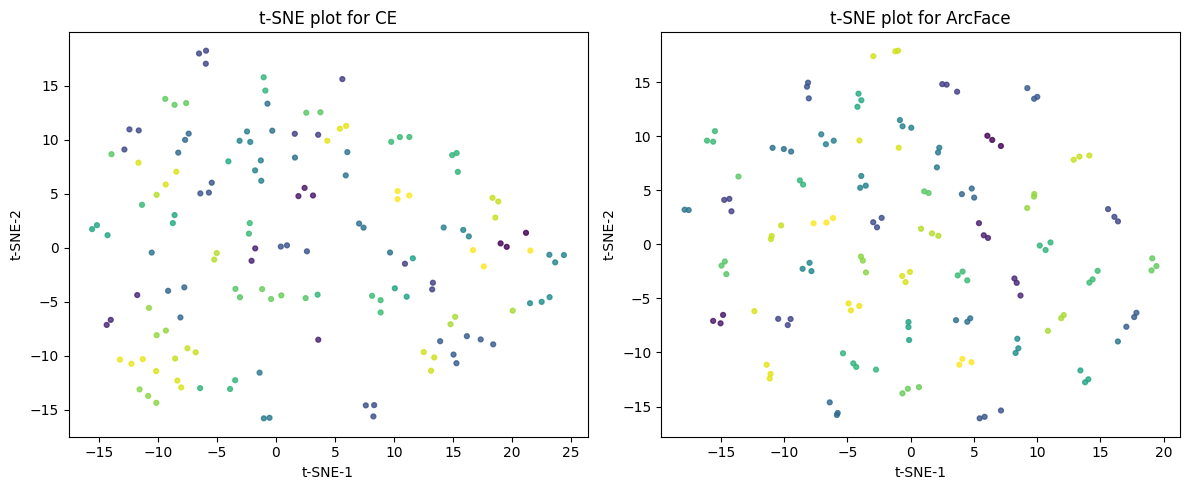

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X2_ce[:,0], X2_ce[:,1], s=12, c=Y_sub, alpha=0.8)
axes[0].set_xlabel("t-SNE-1")
axes[0].set_ylabel("t-SNE-2")
axes[0].set_title("t-SNE plot for CE")

axes[1].scatter(X2_ar[:,0], X2_ar[:,1], s=12, c=Y_sub, alpha=0.8)
axes[1].set_xlabel("t-SNE-1")
axes[1].set_ylabel("t-SNE-2")
axes[1].set_title("t-SNE plot for ArcFace")

plt.tight_layout()

для Arcface точки одного класса собираются плотнее, а разные классы лучше разделены в пространстве

In [44]:
# считаем сosine similarity

def sample_pairs_intra_inter(labels, n_intra, n_inter):

    rng = np.random.default_rng(SEED)
    labels = np.asarray(labels)

    # получаем список уникальных identites
    ids = np.unique(labels)
    by_id = {i: np.where(labels == i)[0] for i in ids}

    # пары одного и того же identity
    intra = []
    eligible = [i for i in ids if len(by_id[i]) >= 2]
    for _ in range(n_intra):
        # случайно выбираем identity и затем два разных индекса внутри него
        i = rng.choice(eligible)
        a, b = rng.choice(by_id[i], size=2, replace=False)
        intra.append((a, b))

    # пары разных identity
    inter = []
    for _ in range(n_inter):
        # выбираем две разные identity и по одному примеру из каждой
        i1, i2 = rng.choice(ids, size=2, replace=False)
        a = rng.choice(by_id[i1])
        b = rng.choice(by_id[i2])
        inter.append((a, b))

    # возвращаем массивы для intra и inter
    return np.asarray(intra, dtype=np.int64), np.asarray(inter, dtype=np.int64)

# вычисляем сosine similarity как скалярное произведение 
def cosine_sim(Z, pairs):
    return np.sum(Z[pairs[:, 0]] * Z[pairs[:, 1]], axis=1)

# создаём выборку пар (intra / inter) для построения гистограмм
intra_pairs, inter_pairs = sample_pairs_intra_inter(Y_sub, n_intra=20000, n_inter=20000)

# считаем косинусные скоры для CE и ArcFace эмбеддингов
ce_intra = cosine_sim(Z_ce_sub, intra_pairs)
ce_inter = cosine_sim(Z_ce_sub, inter_pairs)
ar_intra = cosine_sim(Z_ar_sub, intra_pairs)
ar_inter = cosine_sim(Z_ar_sub, inter_pairs)

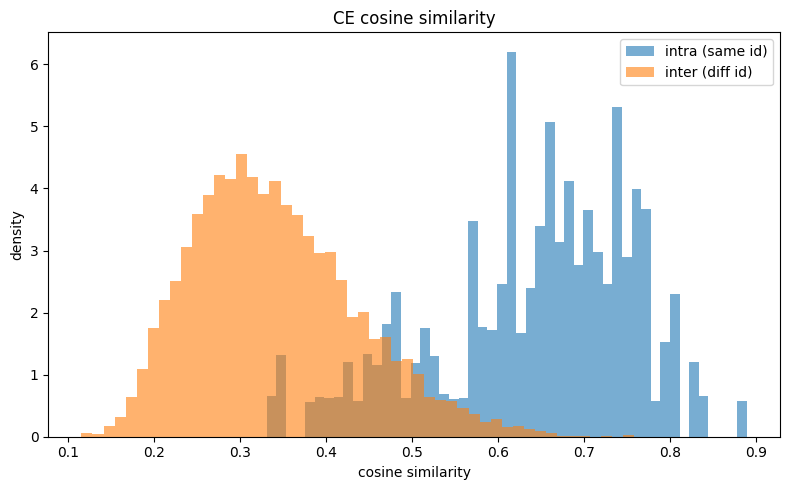

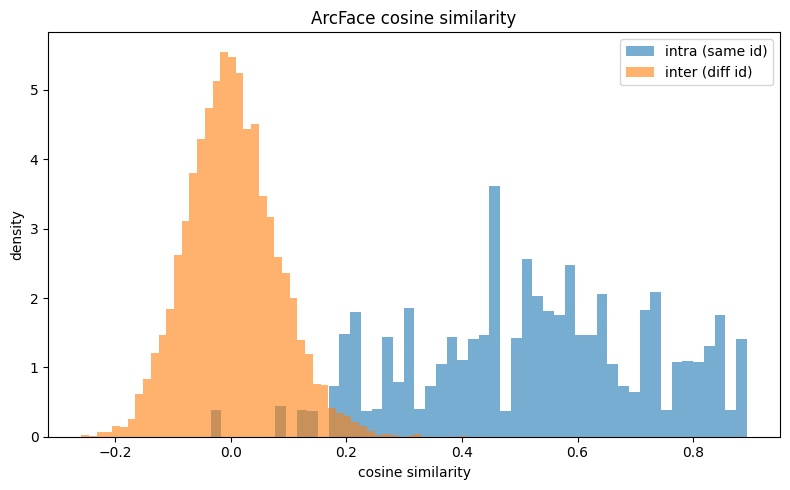

In [45]:
# рисуем гистограммы
plt.figure(figsize=(8, 5))
plt.hist(ce_intra, bins=50, alpha=0.6, label="intra (same id)", density=True)
plt.hist(ce_inter, bins=50, alpha=0.6, label="inter (diff id)", density=True)
plt.title("CE cosine similarity")
plt.xlabel("cosine similarity")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(ar_intra, bins=50, alpha=0.6, label="intra (same id)", density=True)
plt.hist(ar_inter, bins=50, alpha=0.6, label="inter (diff id)", density=True)
plt.title("ArcFace cosine similarity")
plt.xlabel("cosine similarity")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()

для Arcface перекрытие между intra и inter cosine similarity меньше

In [46]:
# теперь вытащим эмбеддинги из всего датасета
Z_ce_full, Y_full = embed_dataset(ds_viz, ce_emb_model, ce_forward_embeddings,
                                 batch_size=128, num_workers=2)
Z_ar_full, _      = embed_dataset(ds_viz, arc_model, arcface_forward_embeddings,
                                 batch_size=128, num_workers=2)

def sample_verification_pairs(labels, n_pos, n_neg):
    rng = np.random.default_rng(SEED)
    labels = np.asarray(labels)

    # получаем список уникальных identites
    ids = np.unique(labels)
    by_id = {i: np.where(labels == i)[0] for i in ids}

    # пары одного и того же identity
    pos = []
    eligible = [i for i in ids if len(by_id[i]) >= 2]
    for _ in range(n_pos):
        # случайно выбираем identity и затем два разные картинки внутри него
        i = rng.choice(eligible)
        a, b = rng.choice(by_id[i], size=2, replace=False)
        pos.append((a, b))

    # пары разных identity
    neg = []
    for _ in range(n_neg):
        # выбираем два разных identity и по одному примеру из каждого
        i1, i2 = rng.choice(ids, size=2, replace=False)
        a = rng.choice(by_id[i1])
        b = rng.choice(by_id[i2])
        neg.append((a, b))

    # объединяем и формируем целевые метки: 1 для положительных пар, 0 для отрицательных
    pairs = np.asarray(pos + neg, dtype=np.int64)
    targets = np.asarray([1] * len(pos) + [0] * len(neg), dtype=np.int64)
    return pairs, targets

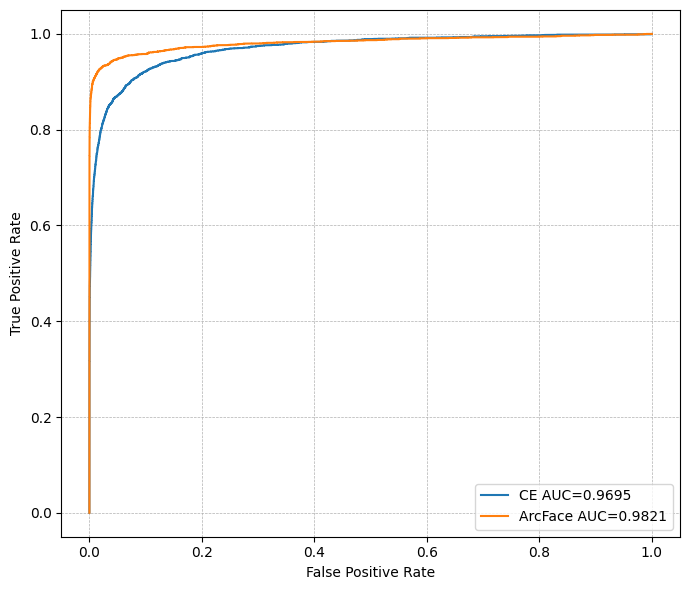

In [47]:
pairs, targets = sample_verification_pairs(Y_full, n_pos=20000, n_neg=20000)

# считаем косинусную похожесть для каждой пары 
s_ce = cosine_sim(Z_ce_full, pairs)
s_ar = cosine_sim(Z_ar_full, pairs)

# строим ROC кривые по скорам 
fpr_ce, tpr_ce, _ = roc_curve(targets, s_ce)
fpr_ar, tpr_ar, _ = roc_curve(targets, s_ar)

# вычисляем AUC
auc_ce = auc(fpr_ce, tpr_ce)
auc_ar = auc(fpr_ar, tpr_ar)

plt.figure(figsize=(7, 6))
plt.plot(fpr_ce, tpr_ce, label=f"CE AUC={auc_ce:.4f}")
plt.plot(fpr_ar, tpr_ar, label=f"ArcFace AUC={auc_ar:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

для Arcface AUC побольше будет